In [1]:
import pandas as pd
import talib as ta
import numpy as np

In [2]:
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data



In [3]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis of unit root).")


In [4]:
def difference_series(series):
    return series.diff()

In [5]:
import matplotlib.pyplot as plt
def plot_stock_data(stock_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [6]:
def split_data(data, train_size=0.8, test_size=0.15):
    train_size = int(train_size * len(data))
    test_size = int(test_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    validation_data = data[train_size+test_size:]
    return train_data, test_data, validation_data

In [7]:
import pandas as pd
import talib

def compute_technical_indicators(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Get a list of columns that are not of type 'datetime' and not of type 'object'
    cols = data.select_dtypes(exclude=['datetime', 'object']).columns

    # Convert these columns to type 'double'
    data[cols] = data[cols].astype('double')

    # Compute Technical Indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
    data['RSI'] = talib.RSI(data['Close'].values, timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macdsignal
    data['MACD_Diff'] = macdhist
    upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB_High'] = upper
    data['BB_Middle'] = middle
    data['BB_Low'] = lower
    data['ATR'] = talib.ATR(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)
    data['OBV'] = talib.OBV(data['Close'].values, data['Volume'].values)
    
    # Drop rows with NaN values created by the indicators
    data.dropna(inplace=True)
    
    return data

In [8]:
# Load and preprocess data for multiple stocks
data = preprocess_stock_data('../../DATASET/VHM.csv')


In [9]:
# Compute technical indicators
data = compute_technical_indicators(data)


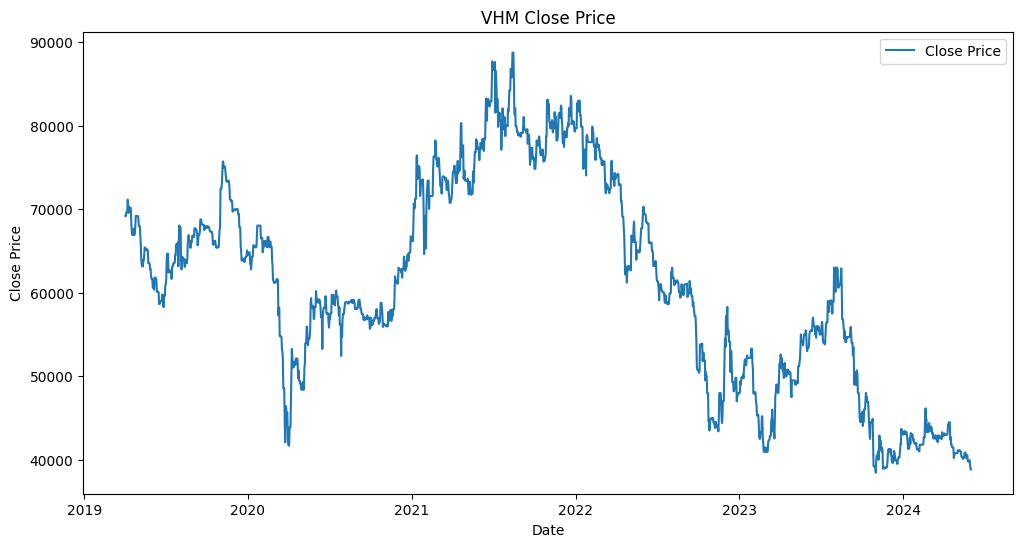

In [10]:
# Plot stock data
plot_stock_data(data, 'VHM Close Price')


In [11]:
vhm_train, vhm_test, vhm_validation = split_data(data)


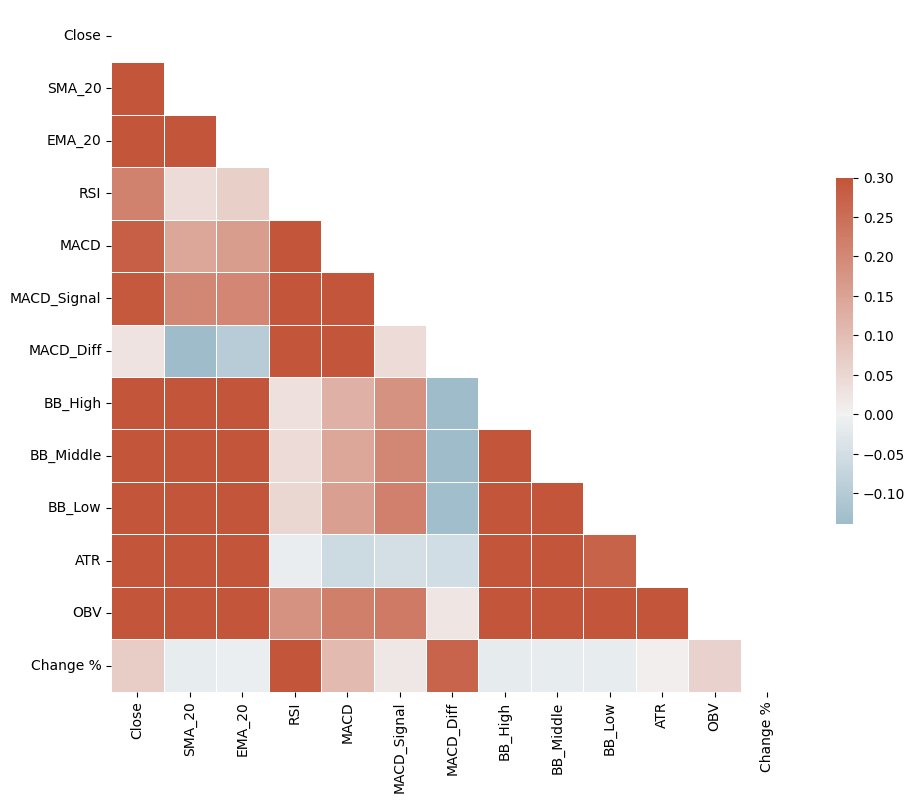

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Choose 'SMA_20', 'MACD_Signal', 'BB_High'(SMA_20 là 1), 'RSI' (MACD_Signal là 1), 'ATR' (là SMA_20)

In [13]:
# Check stationarity of VHM training sets
print("VHM Train Set Stationarity Check:")
check_stationarity(vhm_train['Close'])
check_stationarity(vhm_train['SMA_20'])
check_stationarity(vhm_train['MACD_Signal'])

VHM Train Set Stationarity Check:
ADF Statistic: -1.476773
p-value: 0.544968
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -1.711362
p-value: 0.425268
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -6.031913
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [14]:
# Apply differencing to make the training sets stationary
vhm_train['Close_diff'] = difference_series(vhm_train['Close'])
vhm_train['SMA_20_diff'] = difference_series(vhm_train['SMA_20'])

# Drop the first NaN value generated by differencing
vhm_train.dropna(inplace=True)


/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_50222/3990209801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vhm_train['Close_diff'] = difference_series(vhm_train['Close'])
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_50222/3990209801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vhm_train['SMA_20_diff'] = difference_series(vhm_train['SMA_20'])
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_50222/3990209801.py:6: SettingWithCopyWarning: 
A value is trying t

In [15]:
# Recheck if the VHM training sets are now stationary
print("VHM Train Set Stationarity Check:")
check_stationarity(vhm_train['Close_diff'])
check_stationarity(vhm_train['SMA_20_diff'])


VHM Train Set Stationarity Check:
ADF Statistic: -10.473957
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -5.710339
p-value: 0.000001
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


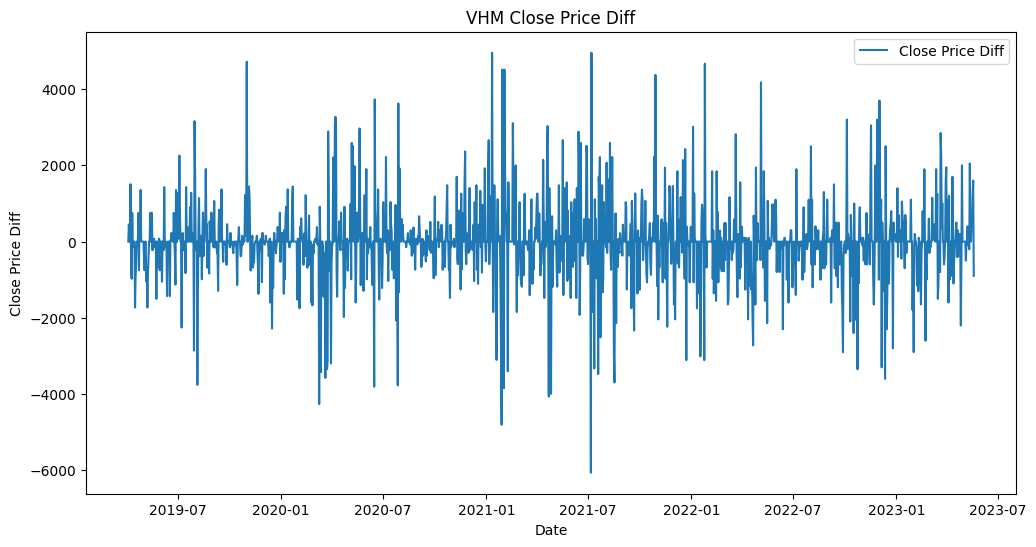

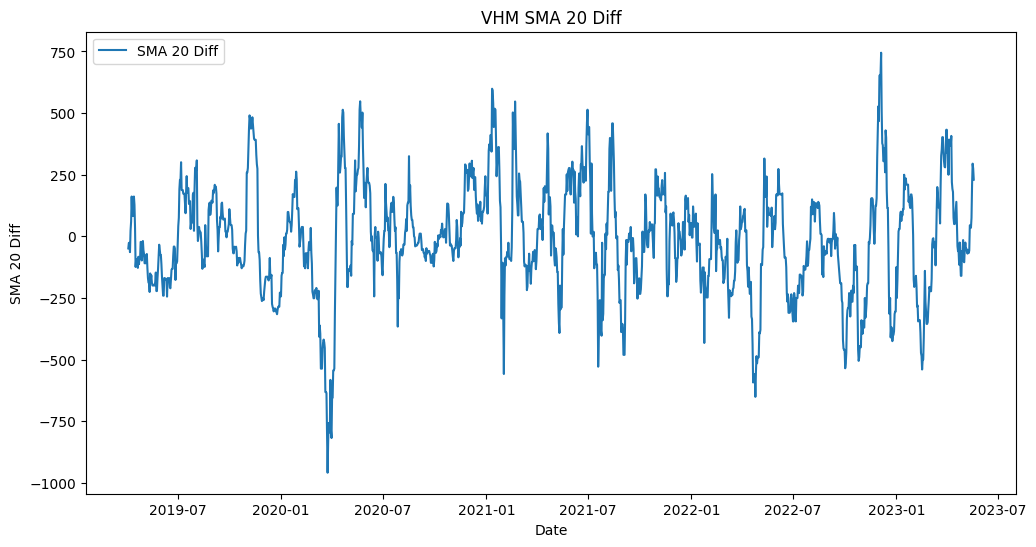

In [16]:
# Plot line chart of VHM close diff
plt.figure(figsize=(12, 6))
plt.plot(vhm_train['Date'], vhm_train['Close_diff'], label='Close Price Diff')
plt.title('VHM Close Price Diff')
plt.xlabel('Date')
plt.ylabel('Close Price Diff')
plt.legend()
plt.show()
# Plot line chart of VHM SMA 20 diff
plt.figure(figsize=(12, 6))
plt.plot(vhm_train['Date'], vhm_train['SMA_20_diff'], label='SMA 20 Diff')
plt.title('VHM SMA 20 Diff')
plt.xlabel('Date')
plt.ylabel('SMA 20 Diff')
plt.legend()
plt.show()

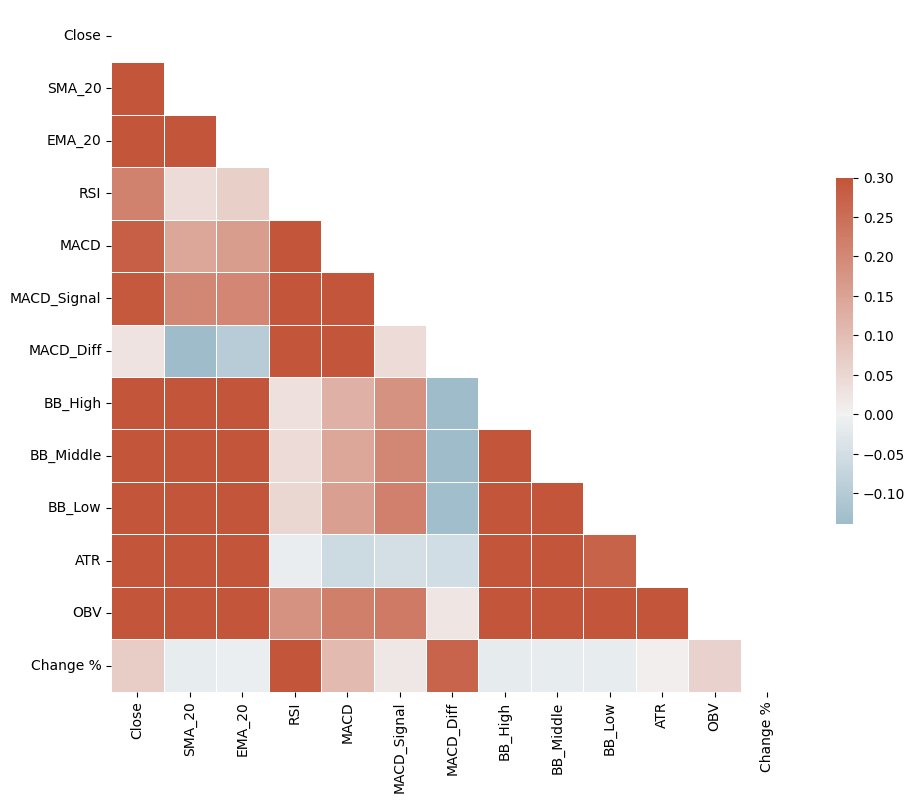

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [19]:
endog_train, endog_test, endog_validation = vhm_train['Close'], vhm_test['Close'], vhm_validation['Close']
exog_train = vhm_train[['SMA_20', 'MACD_Signal']]
exog_test = vhm_test[['SMA_20', 'MACD_Signal']]
exog_validation = vhm_validation[['SMA_20', 'MACD_Signal']]
exog_train

,SMA_20,MACD_Signal
34,68939.65,-22.144687
35,68913.35,-2.510452
36,68887.05,19.433544
37,68823.15,41.630620
38,68845.75,86.723271
...,...,...
1536,49575.00,115.562028
1537,49785.00,192.932687
1538,50080.00,292.090629
1539,50355.00,424.567729


In [20]:
# import the StandardScaler class
from sklearn.preprocessing import StandardScaler
# Scale the Exogenous Variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)
exog_validation_scaled = scaler.transform(exog_validation)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
vhm_train

,Date,Close,Open,High,Low,Volume,Change %,SMA_20,EMA_20,RSI,MACD,MACD_Signal,MACD_Diff,BB_High,BB_Middle,BB_Low,ATR,OBV,Close_diff,SMA_20_diff
34,2019-04-04,69173.0,69699.0,69774.0,68646.0,636410.0,0.0000,68939.65,68904.867708,52.161974,35.119750,-22.144687,57.264437,71240.683444,68939.65,66638.616556,1783.744044,-222180.0,0.0,-48.85
35,2019-04-05,69624.0,69549.0,70075.0,69248.0,590540.0,0.0065,68913.35,68973.356498,54.664657,76.026488,-2.510452,78.536940,71170.043535,68913.35,66656.656465,1720.762327,368360.0,451.0,-26.30
36,2019-04-06,69624.0,69549.0,70075.0,69248.0,590540.0,0.0065,68887.05,69035.322546,54.664657,107.209528,19.433544,87.775984,71097.263336,68887.05,66676.836664,1656.922160,368360.0,0.0,-26.30
37,2019-04-07,69624.0,69549.0,70075.0,69248.0,590540.0,0.0065,68823.15,69091.387065,54.664657,130.418924,41.630620,88.788304,70864.062666,68823.15,66782.237334,1597.642006,368360.0,0.0,-63.90
38,2019-04-08,71128.0,69925.0,71128.0,69699.0,854520.0,0.0216,68845.75,69285.350202,62.775819,267.093876,86.723271,180.370605,70976.275182,68845.75,66715.224818,1590.953291,1222880.0,1504.0,22.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,2023-05-15,51700.0,52000.0,52500.0,51500.0,1700000.0,0.0098,49575.00,50049.211099,67.516783,379.493698,115.562028,263.931670,51604.408781,49575.00,47545.591219,1482.366635,-105619277.0,500.0,75.00
1537,2023-05-16,52200.0,51700.0,52200.0,51500.0,1500000.0,0.0097,49785.00,50254.048137,70.407151,502.415321,192.932687,309.482634,51981.383391,49785.00,47588.616609,1426.483304,-104119277.0,500.0,210.00
1538,2023-05-17,53400.0,52200.0,53900.0,52200.0,3110000.0,0.0230,50080.00,50553.662600,75.940381,688.722401,292.090629,396.631771,52538.739514,50080.00,47621.260486,1446.020211,-101009277.0,1200.0,295.00
1539,2023-05-18,55000.0,53900.0,55800.0,53500.0,3530000.0,0.0300,50355.00,50977.123305,81.032749,954.476125,424.567729,529.908397,53597.977027,50355.00,47112.022973,1514.161625,-97479277.0,1600.0,275.00


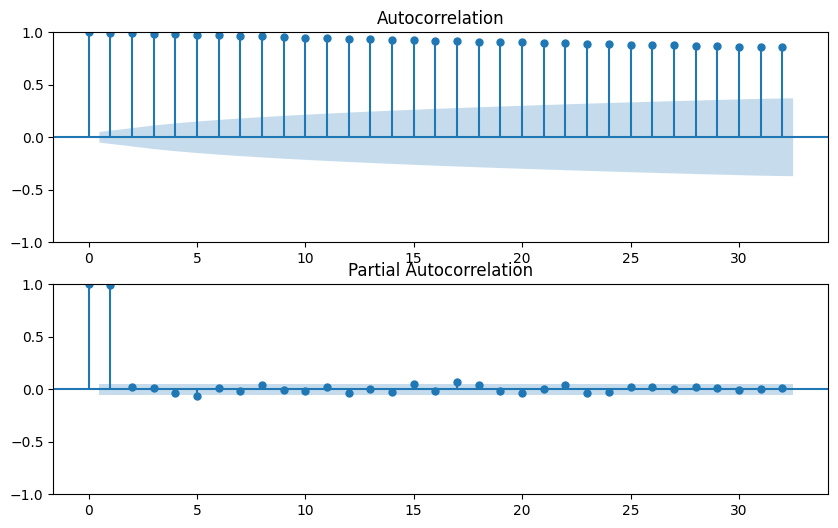

In [22]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(endog_train, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(endog_train, ax=ax2)
plt.show()

In [23]:
import itertools
import statsmodels.api as sm

p = d = q = range(0, 3)  
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(endog=endog_train, exog=exog_train, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f"Best ARIMAX Model: {best_pdq} with AIC: {best_aic}")

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packag

Best ARIMAX Model: (2, 0, 1) with AIC: 24984.07291552139


In [24]:
model = sm.tsa.ARIMA(endog_train, exog=exog_train_scaled, order=best_pdq)
model_fit = model.fit()


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Forecasting
forecast_test = model_fit.forecast(steps=len(endog_test), exog=exog_test_scaled)
forecast_validation = model_fit.forecast(steps=len(endog_validation), exog=exog_validation_scaled)


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


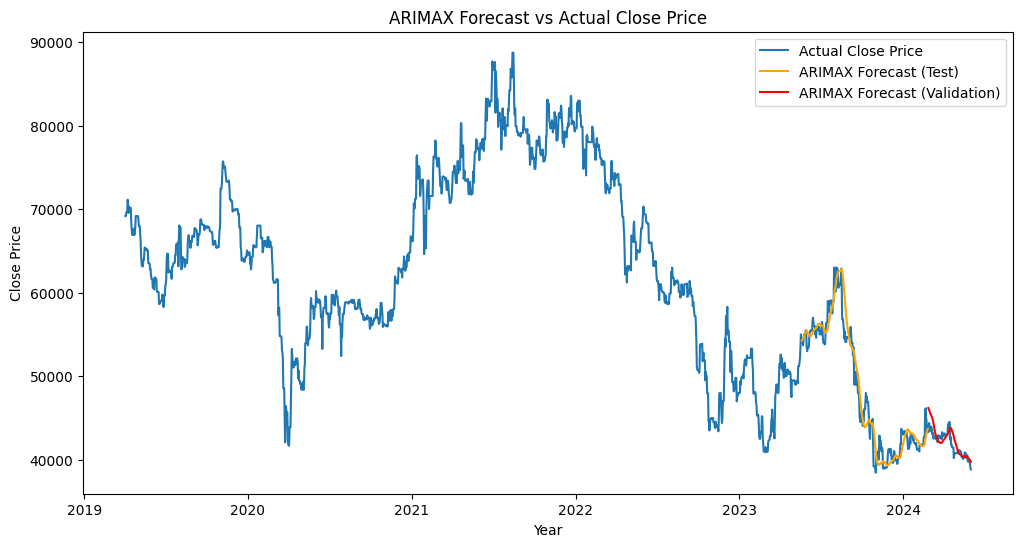

In [26]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['Date'], data['Close'], label='Actual Close Price')
ax.plot(vhm_test['Date'], forecast_test, label='ARIMAX Forecast (Test)', color='orange')
ax.plot(vhm_validation['Date'], forecast_validation, label='ARIMAX Forecast (Validation)', color='red')
ax.set_title('ARIMAX Forecast vs Actual Close Price')
ax.set_xlabel('Year')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/willphan_43/.pye

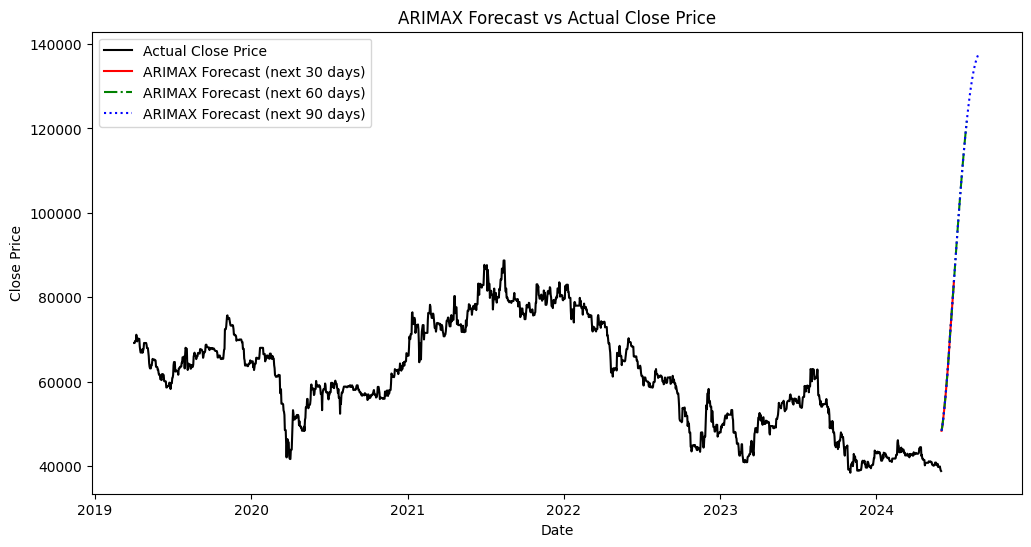

In [27]:
def predict_and_update(data, model_fit, scaler, steps):
    predictions = []
    future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=steps+1, freq='D')[1:]
    
    for _ in range(steps):
        exog = scaler.transform(data[['SMA_20', 'MACD_Signal']].iloc[-1:].values.reshape(1, -1))
        forecast = model_fit.forecast(steps=1, exog=exog)
        
        if isinstance(forecast, np.ndarray) or isinstance(forecast, list):
            forecast_value = forecast[0]
        elif isinstance(forecast, pd.Series) or isinstance(forecast, pd.DataFrame):
            forecast_value = forecast.iloc[0]
        else:
            raise ValueError("Unsupported forecast return type")
        
        predictions.append(forecast_value)
        
        new_row = pd.DataFrame({'Date': [future_dates[_]], 'Close': [forecast_value]})
        data = pd.concat([data, new_row], ignore_index=True)
        
        data["SMA_20"] = data['Close'].rolling(window=20).mean()
        macd, macdsignal, macdhist = ta.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        data['MACD'] = macd
        data['MACD_Signal'] = macdsignal
        data['MACD_Diff'] = macdhist
    
    return future_dates, predictions

def plot_forecasts(data, forecasts, labels, colors, styles):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data['Date'], data['Close'], label='Actual Close Price', color='black', linestyle='-')
    
    for forecast, label, color, style in zip(forecasts, labels, colors, styles):
        ax.plot(forecast[0], forecast[1], label=label, color=color, linestyle=style)
    
    ax.set_title('ARIMAX Forecast vs Actual Close Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    plt.legend()
    plt.show()

scaler = StandardScaler()
scaler.fit(data[['SMA_20', 'MACD_Signal']])

# Predict and plot
forecasts = []
labels = ['ARIMAX Forecast (next 30 days)', 'ARIMAX Forecast (next 60 days)', 'ARIMAX Forecast (next 90 days)']
colors = ['red', 'green', 'blue']

# Generate 90-day forecast first
if len(data) > 0:
    future_dates_90, predictions_90 = predict_and_update(data.copy(), model_fit, scaler, 90)
    forecasts.append((future_dates_90[:30], predictions_90[:30]))  # 30-day forecast
    forecasts.append((future_dates_90[:60], predictions_90[:60]))  # 60-day forecast
    forecasts.append((future_dates_90, predictions_90))  # 90-day forecast
styles = ['-', '-.', ':']
plot_forecasts(data, forecasts, labels, colors, styles)

In [28]:
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming `model_fit` is your fitted model and `exog_test` is your test set for exogenous variables
predictions = model_fit.predict(start=len(endog_train), end=len(endog_train) + len(endog_test) - 1, exog=exog_test)

# Calculate RMSE
# Valid rmse
rmse = np.sqrt(mean_squared_error(endog_validation, forecast_validation))
print(f'Validation RMSE: {rmse}')
# Test rmse
rmse = np.sqrt(mean_squared_error(endog_test, forecast_test))
print(f'Testing RMSE: {rmse}')


# Calculate MDA without relying on indices
# Valid mda
valid_mda = np.mean((np.sign(np.diff(endog_validation.values)) == np.sign(np.diff(predictions[:len(endog_validation)].values))).astype(int))
print(f'Validation Mean Directional Accuracy: {valid_mda}')
# Test mda
test_mda = np.mean((np.sign(np.diff(endog_test.values)) == np.sign(np.diff(predictions[-len(endog_test):].values))).astype(int))
print(f'Testing Mean Directional Accuracy: {test_mda}')
# Calculate MAPE
# Valid mape
mape = np.mean(np.abs((endog_validation - forecast_validation) / endog_validation)) * 100
print(f'Validation Mean Absolute Percentage Error: {mape}')
# Test mape
mape = np.mean(np.abs((endog_test - predictions) / endog_test)) * 100
print(f'Testing Mean Absolute Percentage Error: {mape}')


Validation RMSE: 1040.4174671827163
Testing RMSE: 1678.447846564439
Validation Mean Directional Accuracy: 0.3263157894736842
Testing Mean Directional Accuracy: 0.34519572953736655
Validation Mean Absolute Percentage Error: nan
Testing Mean Absolute Percentage Error: 1033007.9350891632


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
